In [ ]:
#https://d4nst.github.io/2017/01/12/image-orientation/

In [94]:
# Import packages 
import os 
import torch 
import torch.nn as nn
from torch.autograd import Variable 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim 
import torchvision
import numpy as np
from torchsummary import summary
#from torchvision import transforms

In [95]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    

In [96]:
n_epochs =2
batch_size=100
learning_rate =0.01
momentum =0.9
log_interval =10
rotation = 90 

random_seed =2046
torch.backends.cudnn.enabled =False
torch.manual_seed(random_seed)

In [89]:
### Use Horizontal Flip 
data_transforms_horizontal = transforms.Compose([
    transforms.Scale(28),
  transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.5081,))
])

In [105]:
### USe Vertical Flip 
data_transforms_vertical = transforms.Compose([
    transforms.Scale(28),
  transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.5081,))
])

In [139]:
#### rotate with custon angle
data_transforms_rotations = transforms.Compose([
    transforms.Scale(28),
    transforms.RandomRotation((90,90)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.5081,))
])

In [140]:
"""
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.5081,)])
          
          
          ### Torch Vision offers a lot of transformation, such as cropping or normalization 
trans_norm= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(1.0,)),    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip()])
    
    
    
 transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip()
])

dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

show_dataset(dataset)
"""


"\ndata_transform = transforms.Compose([\n        transforms.RandomSizedCrop(224),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n          transforms.Normalize((0.1307,), (0.5081,)])\n          \n          \n          ### Torch Vision offers a lot of transformation, such as cropping or normalization \ntrans_norm= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(1.0,)),    ImgAugTransform(),\n    lambda x: PIL.Image.fromarray(x),\n    torchvision.transforms.RandomVerticalFlip()])\n    \n    \n    \n transforms = torchvision.transforms.Compose([\n    ImgAugTransform(),\n    lambda x: PIL.Image.fromarray(x),\n    torchvision.transforms.RandomVerticalFlip()\n])\n\ndataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)\n\nshow_dataset(dataset)\n"

In [141]:
train_set = datasets.MNIST(root=root, train =True, transform =data_transforms_rotations, download= True)
test_set = datasets.MNIST(root=root, train =False, transform =data_transforms_rotations, download= True)

In [142]:
print (len(train_set))
print (len(test_set))

60000
10000


In [143]:
#Define the batch size
batch_size= 100

## load the dataset
#Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size= batch_size, shuffle= True)
test_loader= torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

print ('Total Training Batch Number: {}'.format(len(train_loader)))
print ('Total Test Batch Number: {}'.format(len(test_loader)))

Total Training Batch Number: 600
Total Test Batch Number: 100


In [144]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [145]:
example_data.shape

torch.Size([100, 1, 28, 28])

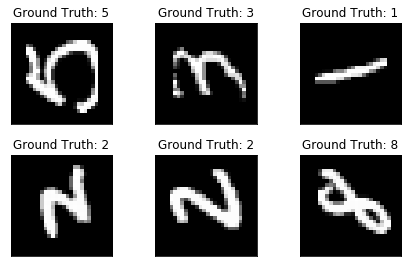

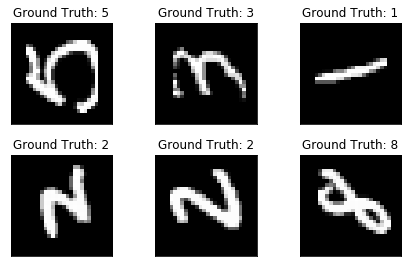

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [150]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [151]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [152]:
summary(network, (1, 28, 28))

C:\Users\Biswash\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [153]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [154]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'D:/PhD_IT/ML_class/model_rotation.pth')
      torch.save(optimizer.state_dict(), 'D:/PhD_IT/ML_class/optimizer_rotation.pth')

In [155]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [156]:
test()
for epoch in range(1, n_epochs+1):
  train(epoch)
  test()

C:\Users\Biswash\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3137, Accuracy: 989/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326929
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.317420
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.285907
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.293365
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.215329
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.145231
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.978567
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.819432
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.542487
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.423718
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.205225
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.786179
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.980577
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.905427
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.828304
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.751163
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.640269
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.537931
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.779402
Train Epoch: 

In [157]:
print (len(train_counter))
print (len(train_losses))

120
120


In [158]:
print (len(test_counter))
print (len(test_losses))

3
3


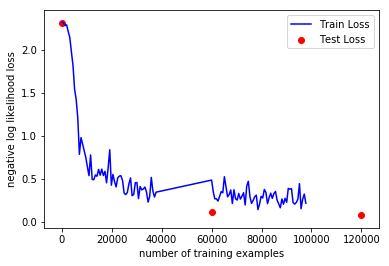

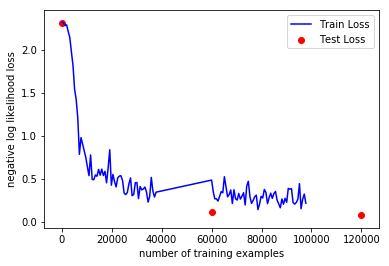

In [159]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

plt.scatter(test_counter[0:3], test_losses[0:3], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples')
plt.ylabel('negative log likelihood loss')
fig